# Clustering based on similarity matrix
<img src='https://images.unsplash.com/photo-1516307318288-46d4194fe79e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8c2ltaWxhcml0eXxlbnwwfHwwfHw%3D&auto=format&fit=crop&w=500&q=60'>

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings(action='ignore') 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

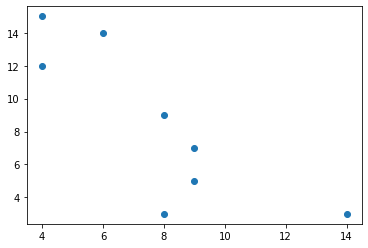

In [31]:
from sklearn.neighbors import NearestNeighbors
X = np.array([(4,15), (6,14), (4,12), (8,9), (9,7), (9,5), (8,3), (14,3)])
plt.scatter(X[:, 0], X[:, 1])

,0,1
0,4,15
1,6,14
2,4,12
3,8,9
4,9,7
5,9,5
6,8,3
7,14,3


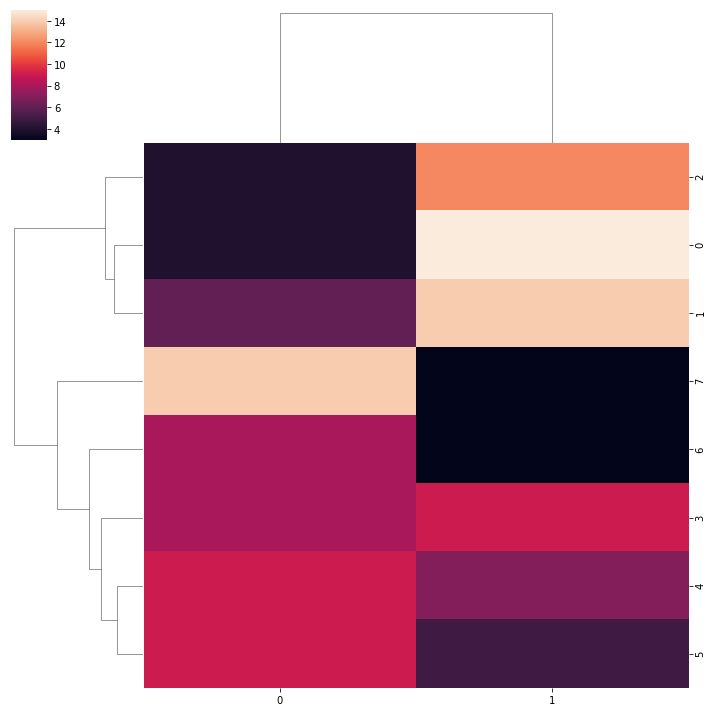

In [32]:
pd.DataFrame(X)
sns.clustermap(X)

## 1. Generating similarity matrix

In [33]:
nbrs = NearestNeighbors(n_neighbors=8, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

print(f'각 인스턴스별로 자신을 포함하여 가장 가까운 인스턴스의 인덱스 :\n{indices}\n\n')
print(f'각 인스턴스별로 자신을 포함하여 가장 가까운 인스턴스와의 거리')
pd.DataFrame(distances)

각 인스턴스별로 자신을 포함하여 가장 가까운 인스턴스의 인덱스 :
[[0 1 2 3 4 5 6 7]
 [1 0 2 3 4 5 6 7]
 [2 1 0 3 4 5 6 7]
 [3 4 5 2 1 6 0 7]
 [4 5 3 6 7 2 1 0]
 [5 4 6 3 7 2 1 0]
 [6 5 4 3 7 2 1 0]
 [7 5 6 4 3 2 1 0]]


각 인스턴스별로 자신을 포함하여 가장 가까운 인스턴스와의 거리


,0,1,2,3,4,5,6,7
0,0.0,2.236068,3.000000,7.211103,9.433981,11.180340,12.649111,15.620499
1,0.0,2.236068,2.828427,5.385165,7.615773,9.486833,11.180340,13.601471
2,0.0,2.828427,3.000000,5.000000,7.071068,8.602325,9.848858,13.453624
3,0.0,2.236068,4.123106,5.000000,5.385165,6.000000,7.211103,8.485281
4,0.0,2.000000,2.236068,4.123106,6.403124,7.071068,7.615773,9.433981
5,0.0,2.000000,2.236068,4.123106,5.385165,8.602325,9.486833,11.180340
6,0.0,2.236068,4.123106,6.000000,6.000000,9.848858,11.180340,12.649111
7,0.0,5.385165,6.000000,6.403124,8.485281,13.453624,13.601471,15.620499


<AxesSubplot:>

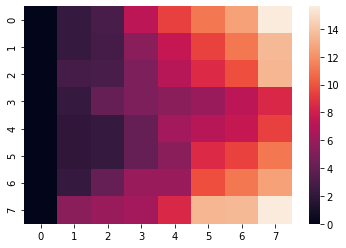

In [34]:
sns.heatmap(distances)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


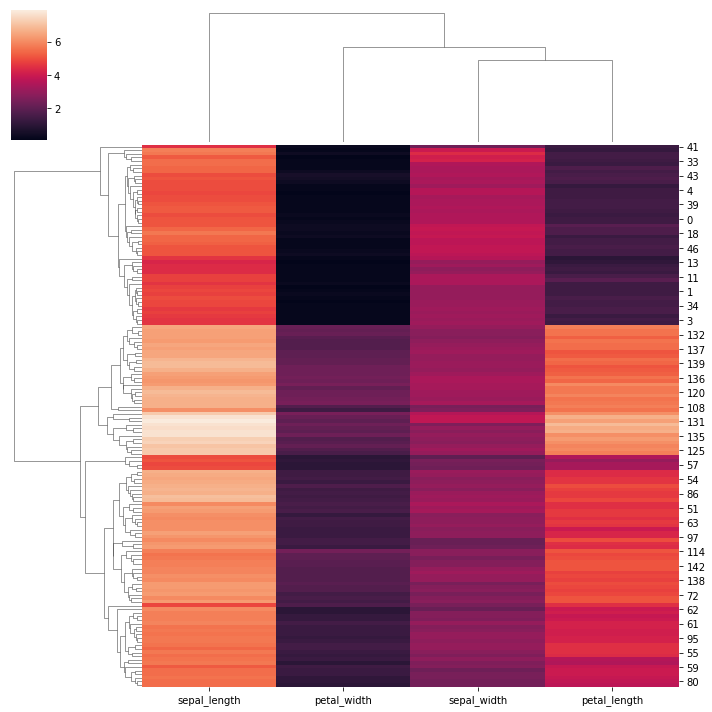

In [35]:
iris = sns.load_dataset("iris")
species = iris.pop("species")
iris
g = sns.clustermap(iris)

# How to ensemble Clustering Algorithms
## K-Means like you’ve never seen before
- https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265
- https://github.com/jaumpedro214/posts/blob/main/ensamble_clustering/ensamble_clustering.ipynb

In [37]:
from scipy.spatial.distance import cdist
import numpy as np

class ClusterSimilarityMatrix():
    
    def __init__(self) -> None:
        self._is_fitted = False

    def fit(self, y_clusters):
        if not self._is_fitted:
            self._is_fitted = True
            self.similarity = self.to_binary_matrix(y_clusters)
            return self

        self.similarity += self.to_binary_matrix(y_clusters)

    def to_binary_matrix(self, y_clusters):
        y_reshaped = np.expand_dims(y_clusters, axis=-1)
        return (cdist(y_reshaped, y_reshaped, 'cityblock')==0).astype(int)


class EnsembleCustering():
    
    def __init__(self, base_estimators, aggregator, distances=False):
        self.base_estimators = base_estimators
        self.aggregator = aggregator
        self.distances = distances

    def fit(self, X):
        X_ = X.copy()

        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.base_estimators:
            clt_sim_matrix.fit(model.fit_predict(X=X_))
        
        sim_matrix = clt_sim_matrix.similarity
        self.cluster_matrix = sim_matrix/sim_matrix.diagonal()

        if self.distances:
            self.cluster_matrix = np.abs(np.log(self.cluster_matrix + 1e-8)) # Avoid log(0)

    def fit_predict(self, X):
        self.fit(X)
        y = self.aggregator.fit_predict(self.cluster_matrix)
        return y

In [39]:
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering
#from simlarity_matrix import ClusterSimilarityMatrix, EnsembleCustering

from sklearn.datasets import make_moons, make_blobs
from scipy.sparse.csgraph import connected_components

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

<AxesSubplot:>

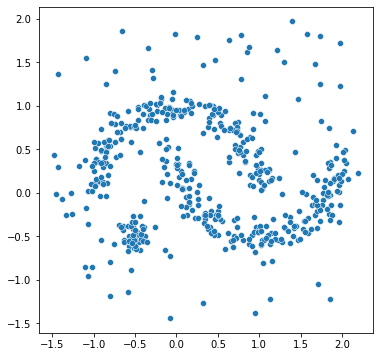

In [40]:
np.random.seed(214)
X_moons, _ = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, _ = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

X_vectors = np.vstack([X_moons, X_blobs, X_noise])

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=X_vectors[:,0], y=X_vectors[:,1], ax=ax)

In [64]:
NUM_KMEANS = 32
MIN_PROBABILITY = 0.6

# Generating a "Cluster Forest"
clustering_models = NUM_KMEANS*[
    # Note: Do not set a random_state, as the variability is crucial
    # This is a extreme simple K-Means
    MiniBatchKMeans(n_clusters= 16, batch_size=64, n_init=1, max_iter=20)
]

clt_sim_matrix = ClusterSimilarityMatrix()
for model in clustering_models:
    clt_sim_matrix.fit(model.fit_predict(X=X_vectors) ) 

sim_matrix = clt_sim_matrix.similarity
norm_sim_matrix = sim_matrix/sim_matrix.diagonal()

# Transforming the probabilities into graph edges
# This is very similar to DBSCAN
graph = (norm_sim_matrix>MIN_PROBABILITY).astype(int)

# Extractin the connected components
n_clusters, y_ensemble = connected_components( graph, directed=False, return_labels=True )

# Default K-Means
y_kmeans = KMeans(n_clusters= 3).fit_predict(X_vectors)

### 32회 수행 500개 인스턴스로 각각 2개 의 인스턴스가 같은 그룹에 속한 횟수
- '0'번째와 '5'번째는 총 32회 중에서 26회에 동일한 클러스터에 속함

In [67]:
pd.DataFrame(sim_matrix)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,32,0,0,0,0,26,0,0,0,0,...,0,0,0,10,0,0,0,0,22,9
1,0,32,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,32,31,0,0,0,0,0,...,0,0,0,10,0,25,0,0,1,0
4,0,0,0,31,32,0,0,0,0,0,...,0,0,0,11,0,24,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,25,24,0,0,0,0,0,...,0,0,0,6,0,32,0,2,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,32,14,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,14,32,0,0
498,22,0,1,1,1,28,0,0,0,0,...,0,0,0,19,0,0,0,0,32,8


<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, '32x K-Means models(n_clusters=16)\n Graph cut prabibility = 0.6')

Text(0.5, 1.0, 'Default K-Means model(n_clusters= 3)\n')

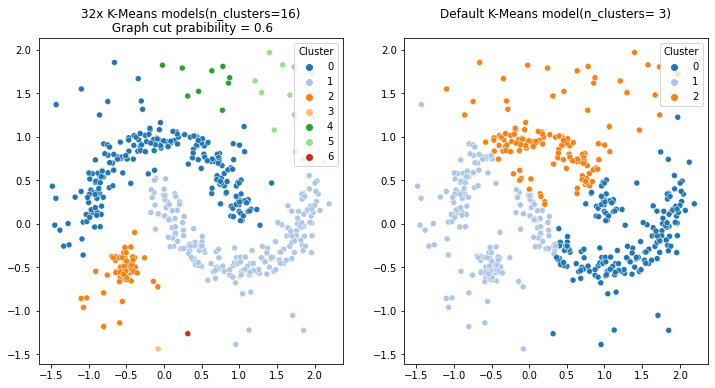

In [65]:
fig, ax = plt.subplots( figsize=(12,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_ensemble, 
    palette='tab20',
    ax=ax[0]
)

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_kmeans, 
    palette='tab20',
    ax=ax[1]
)

ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"{NUM_KMEANS}x K-Means models(n_clusters=16)\n Graph cut prabibility = {MIN_PROBABILITY}")
ax[1].set_title(f"Default K-Means model(n_clusters= 3)\n")

## Spectral Clustering solo vs Spectral Clustering & K-Means

In [62]:
NUM_KMEANS = 128

clustering_models = NUM_KMEANS*[
    # Note: Do not set a random_state, as the variability is crucial
    MiniBatchKMeans(n_clusters=16, batch_size=64, n_init=1, max_iter=20)
]
aggregator_clt = SpectralClustering(n_clusters=3, affinity="precomputed")

ens_clt=EnsembleCustering(clustering_models, aggregator_clt)
y_ensemble = ens_clt.fit_predict(X_vectors)

# Default Spectral Clustering model 
y_spectral = SpectralClustering(n_clusters=3).fit_predict(X_vectors)

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, '128x K-Means models(n_clusters=16)\n SpectralClustering(n_clusters=3)')

Text(0.5, 1.0, 'Default\nSpectralClustering(n_clusters=3)')

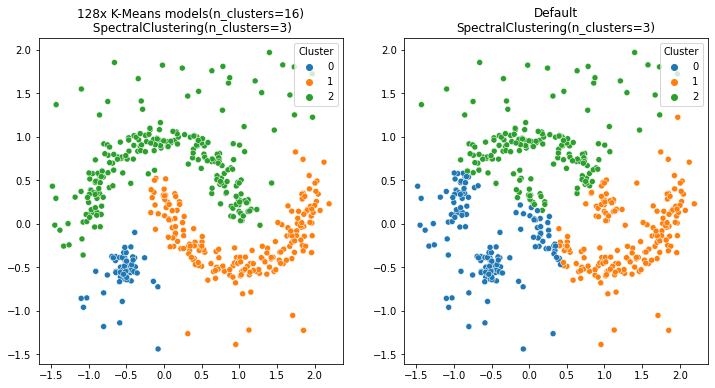

In [63]:
fig, ax = plt.subplots( figsize=(12,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_ensemble, 
    palette='tab10',
    ax=ax[0]
)

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=y_spectral, 
    palette='tab10',
    ax=ax[1]
)

ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"{NUM_KMEANS}x K-Means models(n_clusters=16)\n SpectralClustering(n_clusters=3)")
ax[1].set_title(f"Default\nSpectralClustering(n_clusters=3)")

# End